In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import torch
import time
import xarray as xr
import pickle
import matplotlib.pyplot as plt
from scipy.linalg import cholesky

import sys
from os.path import dirname, join, abspath

from brainmodel_utils.neural_mappers.utils import convert_dict_to_tuple
from brainmodel_utils.metrics.consistency import get_linregress_consistency

#DATA_ROOT = "/data/group_data/neuroagents_lab/neural_datasets/zfa_data"
sys.path.insert(0, abspath(join(dirname("default_dirs.py"), '..')))
from zfa.core.default_dirs import (
    BASE_DIR,
    NEURAL_TRIALS_PATH,
    GLIAL_TRIALS_PATH,
    INTER_ANIMAL_RESULTS_DIR,
)

sys.path.insert(0, abspath(join(dirname("utils.py"), '..')))
from zfa.data_comparisons.utils import load_data_tensors

sys.path.insert(0, abspath(join(dirname("rdk_bang_bang.py"), '..')))
from scripts.python_scripts.rdk_bang_bang import run_sim, visualize_results

In [2]:
# Simulation parameters
sim_params = {
    'duration': 20000,  # Duration of the whole simulation in ms
    'open_loop_start_and_end_time': [5000 - 1, 9000],  # Open loop start and end times
    'drift_speed': 1,  # Striped bar drift speed
    'motosensory_gain': 2  # Gain from agent swimming power to stripes
}

# Agent parameters
agent_params = {
    'f_integration_tau': 5000,
    'f_integration_decay_constant': 2,
    'f_integration_gain': 10,
    'f_threshold': 1.6,  # Astrocyte activity threshold for giving up
    'gaba_gain':int(1e6),
    'gaba_threshold': 0.1
}

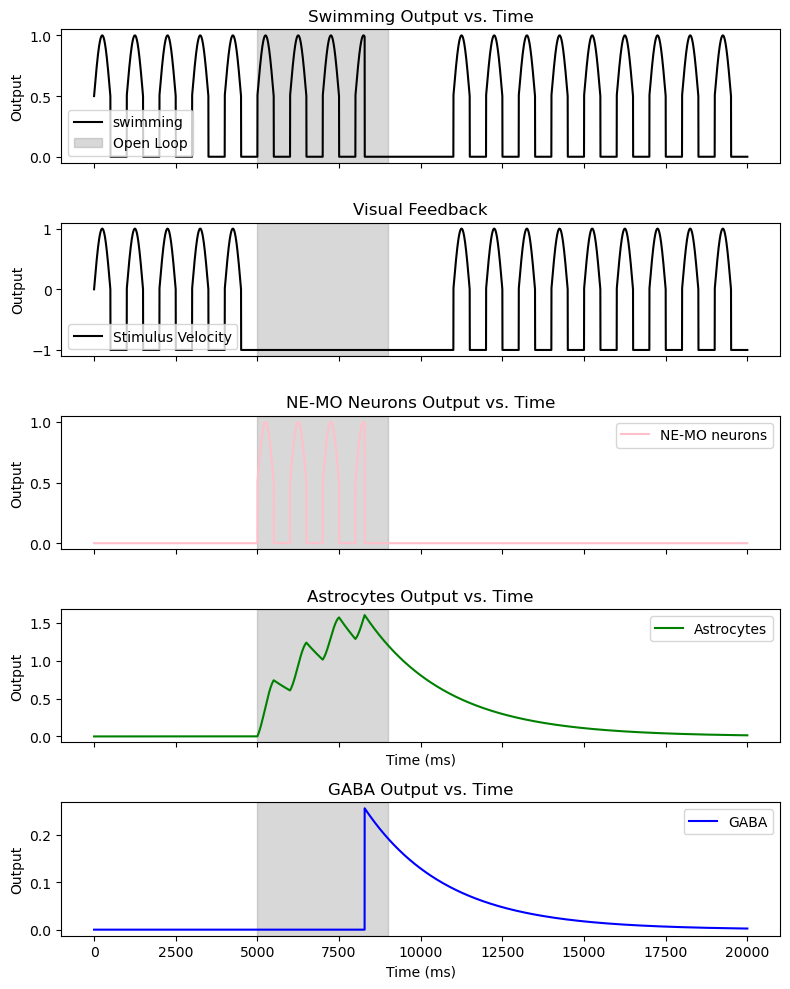

In [3]:
# Run the simulation
results = run_sim(sim_params, agent_params)

# Extract the open loop times
open_loop_start_time, open_loop_end_time = sim_params['open_loop_start_and_end_time']

# Plot results
visualize_results(results, open_loop_start_time, open_loop_end_time)



In [4]:
neural_brain_data, glial_brain_data, _, _, _ = load_data_tensors()

ANIMALS = list(neural_brain_data.keys())
target_animal = ANIMALS[1]
source_animal = ANIMALS[0]
source_brain_data = glial_brain_data[source_animal]#[:,:,0:1000]
target_brain_data = glial_brain_data[target_animal]#[:,:,0:5000]

 ---Loading data tensors---  


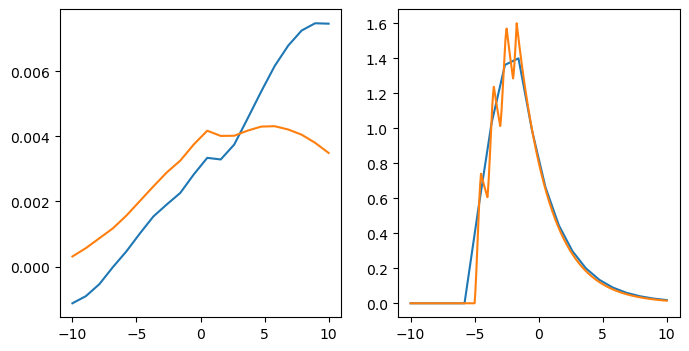

In [5]:
X_1Hz = np.asarray(source_brain_data.coords['time']).reshape(-1, 1)
X_1000Hz = np.linspace(-10, 10, 20000)

fig = plt.figure(figsize=(8, 4))
mean_time_series_source = np.asarray(source_brain_data.mean(dim = 'trials').mean(dim = 'units'))
mean_time_series_target = np.asarray(target_brain_data.mean(dim = 'trials').mean(dim = 'units'))
glial_ramp_1000Hz = results['f_integrator']
glial_ramp_1Hz = results['f_integrator'].reshape(20, 1000)
glial_ramp_1Hz = glial_ramp_1Hz.mean(axis=1)

plt.subplot(1, 2, 1)
plt.plot(X_1Hz, mean_time_series_source, label='glia sesh 3')
plt.plot(X_1Hz, mean_time_series_target, label='glia sesh 4')

plt.subplot(1, 2, 2)
plt.plot(X_1Hz, glial_ramp_1Hz)
plt.plot(X_1000Hz, glial_ramp_1000Hz)
plt.show()

In [6]:
ramp = glial_ramp_1000Hz[open_loop_start_time+1:open_loop_end_time].reshape(20, 200)
ramp = ramp.mean(axis=1)
ramp.shape

(20,)

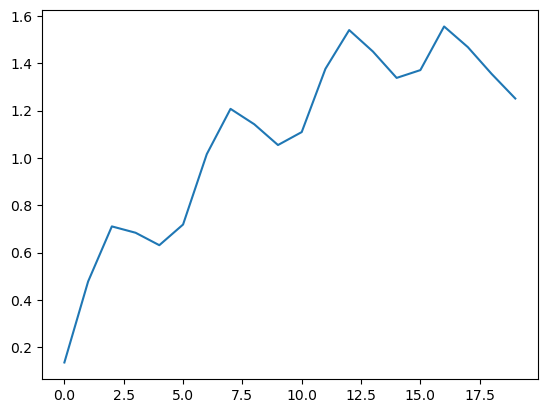

In [7]:
plt.plot(ramp)

In [8]:
neural_brain_data['sub-20170228-3_ses-20170228T165730_ophys']

<xarray.DataArray (trials: 66, time: 20, units: 111378)> Size: 588MB
array([[[ 1.03759766e-02,  4.42886353e-03,  4.55093384e-03, ...,
          1.08108521e-02,  1.42974854e-02,  1.56402588e-02],
        [ 1.57833099e-03,  8.45336914e-03,  1.87377930e-02, ...,
          3.63731384e-03,  1.02920532e-02,  1.07727051e-02],
        [ 1.38015747e-02,  3.18336487e-03,  1.61132812e-02, ...,
          9.69696045e-03,  1.16043091e-02,  1.48849487e-02],
        ...,
        [ 1.02233887e-03, -9.74273682e-03,  2.27928162e-03, ...,
          2.45666504e-03, -8.69750977e-03, -7.07626343e-03],
        [ 6.31809235e-04,  2.14958191e-03,  1.90734863e-03, ...,
         -4.77981567e-03, -3.09562683e-03, -9.23156738e-04],
        [-8.33892822e-03,  4.79507446e-03, -4.03976440e-03, ...,
         -8.75091553e-03, -1.16882324e-02, -5.33676147e-03]],

       [[-1.32217407e-02,  3.68690491e-03, -6.83975220e-03, ...,
         -1.20639801e-03, -1.17721558e-02, -4.37927246e-03],
        [-6.53076172e-03,  2.16960907e-04, -8.02612305e-03, ...,
         -6.07681274e-03, -3.24058533e-03, -3.64685059e-03],
        [-5.98907471e-03, -8.51440430e-03, -1.63879395e-02, ...,
          1.61933899e-03, -5.98907471e-03, -4.78744507e-03],
...
         -1.69563293e-03, -1.13773346e-03, -5.65052032e-04],
        [-8.46862793e-03, -2.20108032e-03, -1.19018555e-02, ...,
         -2.26402283e-03, -1.30748749e-03, -5.09262085e-03],
        [-1.43356323e-02, -3.76510620e-03, -1.50070190e-02, ...,
         -3.50189209e-03, -6.89315796e-03, -6.99996948e-03]],

       [[-3.39508057e-03,  9.10949707e-03, -5.09262085e-03, ...,
          4.98580933e-03,  1.02844238e-02,  6.72531128e-03],
        [-5.86318970e-03,  1.37405396e-02, -3.45039368e-03, ...,
          2.78472900e-03,  4.65774536e-03,  6.35910034e-03],
        [ 1.63269043e-03,  3.93295288e-03,  2.28881836e-03, ...,
          4.32586670e-03,  4.23812866e-03,  8.68988037e-03],
        ...,
        [-1.23977661e-02, -2.12478638e-03, -1.02691650e-02, ...,
         -2.49099731e-03,  1.78456306e-04, -2.71797180e-03],
        [-1.73492432e-02, -7.34329224e-03, -1.72576904e-02, ...,
         -5.46646118e-03, -1.71661377e-03, -4.61959839e-03],
        [-1.67999268e-02, -4.06646729e-03, -5.69915771e-03, ...,
         -1.36375427e-03, -4.80270386e-03, -4.07028198e-03]]],
      dtype=float32)
Coordinates:
  * trials   (trials) int64 528B 0 1 2 3 4 5 6 7 8 ... 58 59 60 61 62 63 64 65
  * time     (time) float64 160B -10.0 -8.947 -7.895 -6.842 ... 7.895 8.947 10.0
  * units    (units) int64 891kB 0 1 2 3 4 ... 111374 111375 111376 111377

In [9]:
# reshape from (20,) to (1, 20)
glial_ramp = glial_ramp_1Hz[np.newaxis, :]


In [10]:
glial_ramp.T.shape

(20, 1)

In [11]:
source_brain_data.coords['time'].shape

(20,)

In [12]:
source_brain_data.coords['units'][:1].shape

(1,)

In [13]:
coords_sample_source = {
    "time": source_brain_data.coords['time'],    # replace with your actual coordinates
    "units": source_brain_data.coords['units'][:1]   # replace with your actual coordinates
}


bang_bang_xarr = xr.DataArray(glial_ramp.T, dims=("time", "units"), coords = coords_sample_source)


In [14]:
bang_bang_xarr

<xarray.DataArray (time: 20, units: 1)> Size: 160B
array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.52810848],
       [1.02800837],
       [1.36307447],
       [1.4005159 ],
       [0.99061111],
       [0.66397335],
       [0.44503903],
       [0.29829471],
       [0.19993693],
       [0.13401101],
       [0.08982308],
       [0.06020539],
       [0.04035365],
       [0.0270477 ],
       [0.01812916]])
Coordinates:
  * time     (time) float64 160B -10.0 -8.947 -7.895 -6.842 ... 7.895 8.947 10.0
  * units    (units) int64 8B 0

In [15]:
 #save and check to see if loading save works
 
 def pickle_load(file_path):
    with open(file_path, 'rb') as handle:
        data = pickle.load(handle)
    return data
 
 #save the data
with open(BASE_DIR + 'bang_bang.pickle', 'wb') as handle:
    pickle.dump(bang_bang_xarr, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [16]:
 BASE_DIR

'/data/user_data/rdkeller/zfa/'

In [17]:
bb_data = pickle_load(BASE_DIR + 'bang_bang.pickle')

In [18]:
bb_data

<xarray.DataArray (time: 20, units: 1)> Size: 160B
array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.52810848],
       [1.02800837],
       [1.36307447],
       [1.4005159 ],
       [0.99061111],
       [0.66397335],
       [0.44503903],
       [0.29829471],
       [0.19993693],
       [0.13401101],
       [0.08982308],
       [0.06020539],
       [0.04035365],
       [0.0270477 ],
       [0.01812916]])
Coordinates:
  * time     (time) float64 160B -10.0 -8.947 -7.895 -6.842 ... 7.895 8.947 10.0
  * units    (units) int64 8B 0